# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algoritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [1]:
%pip install opencv-python --quiet
%pip install scikit-image --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from skimage.io import imread

from tensorflow import keras
from sklearn.metrics import confusion_matrix

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
class_names_label

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [3]:
# Definimos la ruta raíz donde están las carpetas 'seg_train' y 'seg_test'.
ROOTPATH = r'C:\Users\migue\Downloads\clasificador_paisajes'  # Ruta absoluta a la carpeta principal
ROOTPATH  # Mostramos la ruta para verificar

'C:\\Users\\migue\\Downloads\\clasificador_paisajes'

In [4]:
# Listamos el contenido de la ruta principal para comprobar que existen las carpetas 'seg_train' y 'seg_test'.
os.listdir(ROOTPATH)

['seg_test', 'seg_train']

In [5]:
# Definimos el tamaño de las imágenes y las rutas completas a los conjuntos de entrenamiento y test.
IMAGE_SIZE = (32,32)  # Tamaño al que se redimensionarán las imágenes
TRAIN_PATH = os.path.join(ROOTPATH, 'seg_train')  # Ruta a la carpeta de entrenamiento
TEST_PATH = os.path.join(ROOTPATH, 'seg_test')    # Ruta a la carpeta de test

# Mostramos las rutas para verificar
TRAIN_PATH, TEST_PATH

('C:\\Users\\migue\\Downloads\\clasificador_paisajes\\seg_train',
 'C:\\Users\\migue\\Downloads\\clasificador_paisajes\\seg_test')

In [6]:
# Función mejorada: solo procesa carpetas que sean clases válidas, ignora archivos sueltos

def read_data(path, im_size):
    X = []
    y = []

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        # Solo procesamos si es carpeta y está en class_names_label
        if not os.path.isdir(folder_path):
            continue
        if folder not in class_names_label:
            continue
        label = class_names_label[folder]

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            try:
                image = imread(image_path)
                smallimage = cv2.resize(image, im_size)
                X.append(smallimage)
                y.append(label)
            except:
                print("Error en lectura imagen", image_path)

    return np.array(X), np.array(y)


Forma de X_train: (14034, 32, 32, 3)
Forma de X_test: (3000, 32, 32, 3)
Forma de y_train: (14034,)
Forma de y_test: (3000,)


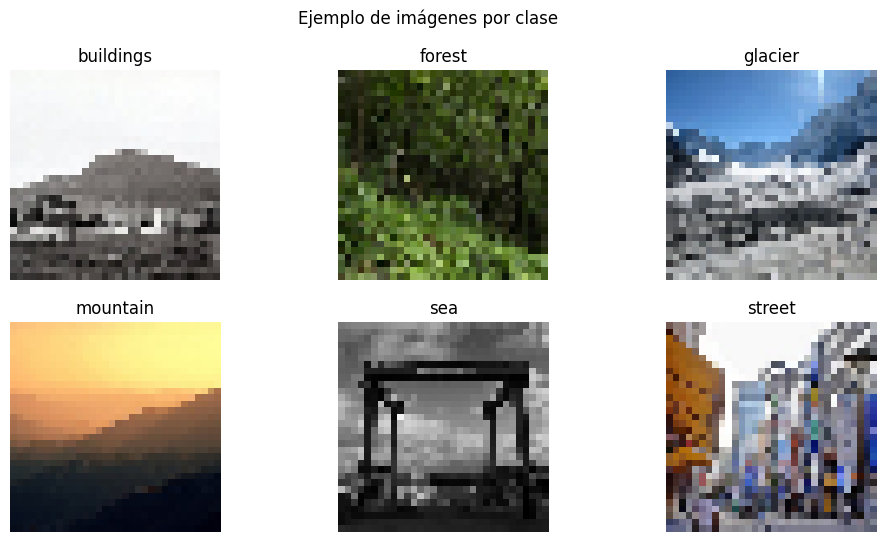

In [7]:
# Cargamos los datos de entrenamiento y test usando la función definida.
X_train, y_train = read_data(TRAIN_PATH, IMAGE_SIZE)
X_test, y_test = read_data(TEST_PATH, IMAGE_SIZE)

# Mostramos las formas de los arrays para comprobar que se han cargado correctamente
print('Forma de X_train:', X_train.shape)
print('Forma de X_test:', X_test.shape)
print('Forma de y_train:', y_train.shape)
print('Forma de y_test:', y_test.shape)

# Mostramos una imagen de ejemplo de cada clase para verificar la carga
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i, class_name in enumerate(class_names):
    idx = np.where(y_train == i)[0][0]  # Primer índice de la clase
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[idx])
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Ejemplo de imágenes por clase')
plt.show()

C:\Users\migue\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,206 (1.20 MB)

 Trainable params: 315,206 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5173 - loss: 1.2098 - val_accuracy: 0.6331 - val_loss: 0.9576
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5173 - loss: 1.2098 - val_accuracy: 0.6331 - val_loss: 0.9576
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6408 - loss: 0.9418 - val_accuracy: 0.6665 - val_loss: 0.8863
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6408 - loss: 0.9418 - val_accuracy: 0.6665 - val_loss: 0.8863
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6738 - loss: 0.8718 - val_accuracy: 0.7207 - val_loss: 0.7651
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6738 - loss: 0.8718 - val_accuracy: 0.7207 - val_loss: 0.7651
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7097 - loss: 0.7870 - val_accuracy: 0.7243 - val_loss: 0.7507
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7097 - loss: 0.7870 - val_accu

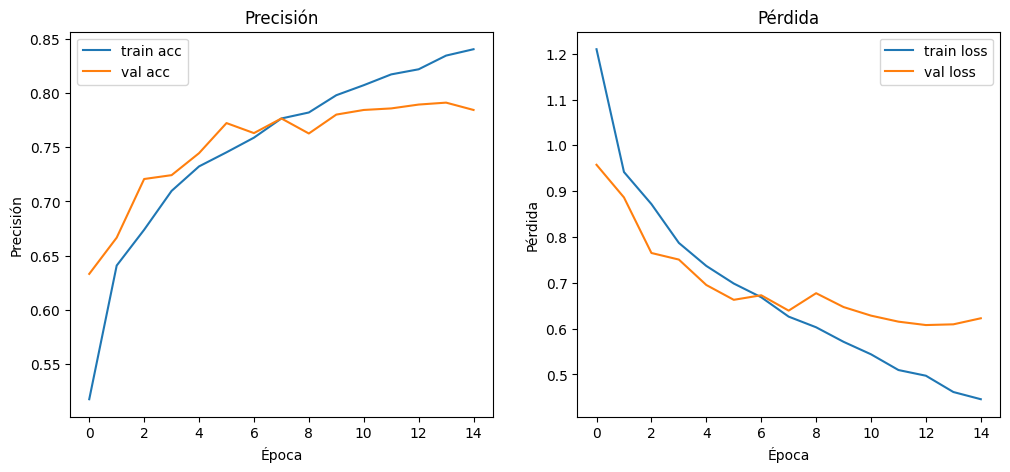

Precisión en test: 0.783
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Nº de errores: 651
Nº de errores: 651


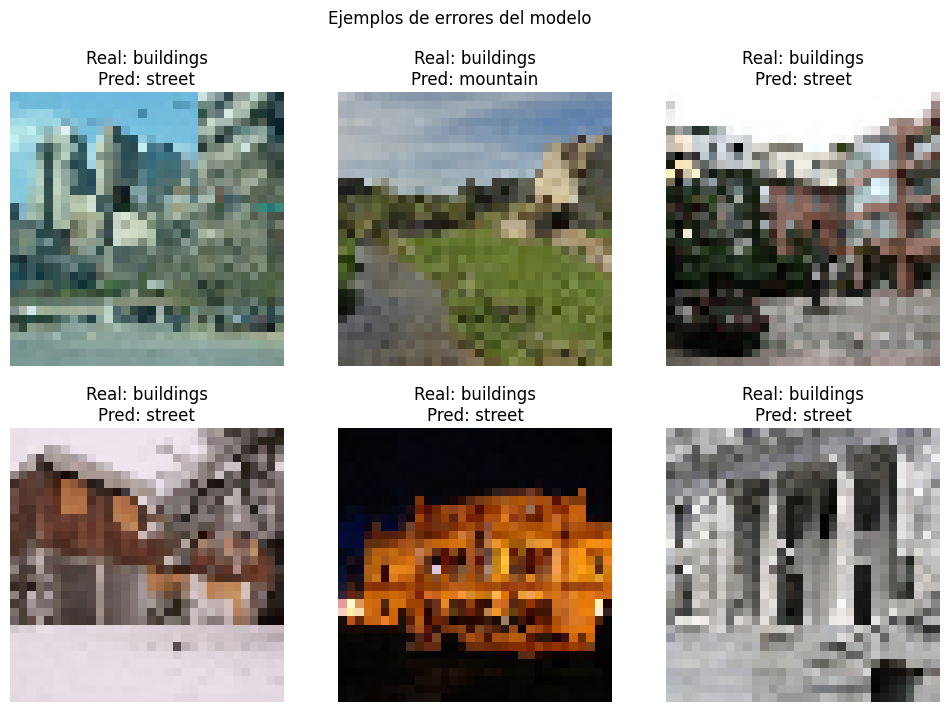

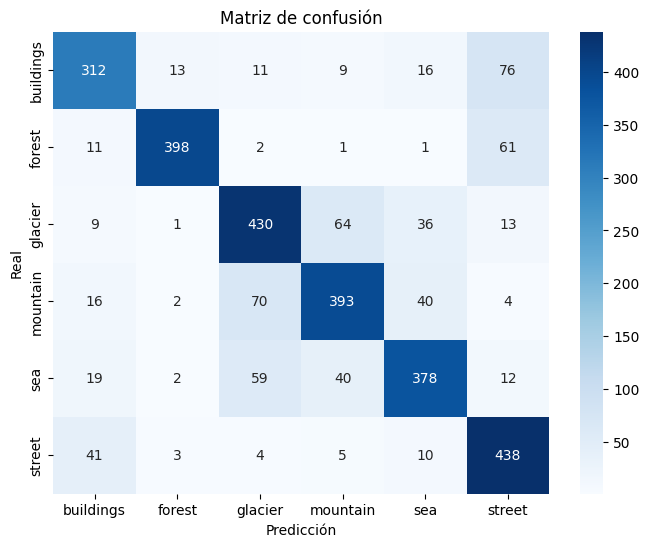

In [8]:
# 3. Normalización de los datos
# Convertimos los valores de píxeles a float y los llevamos al rango [0,1] para facilitar el aprendizaje de la red
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 4. Diseño de la arquitectura de la red y preparación de etiquetas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convertimos las etiquetas numéricas a one-hot encoding (vector binario) para clasificación multiclase
y_train_cat = to_categorical(y_train, num_classes=len(class_names))
y_test_cat = to_categorical(y_test, num_classes=len(class_names))

# 5. Reserva un 20% de los datos del entrenamiento para validar
# Separamos el conjunto de entrenamiento en entrenamiento y validación, manteniendo la proporción de clases
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_cat, test_size=0.2, random_state=42, stratify=y_train)

# Definimos la arquitectura de la red neuronal convolucional (CNN)
model = Sequential([
    # Primera capa convolucional + max pooling
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    MaxPooling2D((2,2)),
    # Segunda capa convolucional + max pooling
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    # Aplanamos la salida para conectarla a la capa densa
    Flatten(),
    # Capa densa totalmente conectada
    Dense(128, activation='relu'),
    # Dropout para evitar overfitting
    Dropout(0.5),
    # Capa de salida con softmax para clasificación multiclase
    Dense(len(class_names), activation='softmax')
])

# Compilamos el modelo con optimizador Adam y función de pérdida adecuada para clasificación multiclase
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 6. Entrenamiento del modelo y representación del objeto history
# Entrenamos la red y guardamos el historial de métricas para graficar después
history = model.fit(
    X_train_split, y_train_split,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val)
 )

# Graficamos la evolución de la precisión y la pérdida durante el entrenamiento
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# 7. Evaluación del modelo con los datos de test
# Evaluamos el modelo entrenado sobre el conjunto de test para ver su rendimiento final
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Precisión en test: {test_acc:.3f}')

# 8. Visualización de errores del modelo
# Obtenemos las predicciones del modelo sobre el test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Buscamos los índices donde la predicción es incorrecta
errores = np.where(y_pred != y_test)[0]
print(f'Nº de errores: {len(errores)}')

# Mostramos 6 imágenes donde el modelo falla, indicando la clase real y la predicha
plt.figure(figsize=(12,8))
for i, idx in enumerate(errores[:6]):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[idx])
    plt.title(f'Real: {class_names[y_test[idx]]}\nPred: {class_names[y_pred[idx]]}')
    plt.axis('off')
plt.suptitle('Ejemplos de errores del modelo')
plt.show()

# 9. Matriz de confusión
# Mostramos la matriz de confusión para analizar los errores por clase
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()